# Quadrotor (aka "the drone") — Tracking Demo

Import modules.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

import ae353_dronecontrol # <--- has a working controller for the purpose of demonstration

pybullet build time: Dec 10 2021 09:55:58


Create and print a seed for the random number generator so it is possible to reproduce the results.

In [2]:
seed = secrets.randbits(32)
print(seed)

926175165


Create simulator with seed.

In [3]:
simulator = ae353_drone.Simulator(
    display=True,
    seed=seed,
)

By default, your controller will fail if either of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `5e-3` seconds for `run`.

You can relax these rules for the purpose of development if you want, as follows.

In [4]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)

Show controller template. The actual controller used in this example comes from `ae353_dronecontrol.py`.

**NOTE. I didn't publish the version of `ae353_dronecontrol.py` that was used in class, rather just the template version. If you want this notebook to work, you'll need to modify `ae353_dronecontrol.py` so that it works!**

In [ ]:
class Controller:
    def __init__(self):
        
        # Define all variables
        #
        # self.A = ...
        # self.B = ...
        # ...
        # ...
        
        self.variables_to_log = ['xhat', 'xdes', 'ring']

    def get_color(self):
        return [1., 0., 0.]

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        
        # Choose initial state estimate
        #
        self.xhat = np.array([p_x_meas, p_y_meas, ])
        
        pass

    def run(
            self,
            t,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        
        # Store ring position for later analysis
        self.ring = np.array([p_x_ring, p_y_ring, p_z_ring])
        
        # Get xdes and udes
        self.xdes, self.udes = self.get_xdes_and_udes(self.xhat, p_x_ring, p_y_ring, p_z_ring)
        
        # Apply controller and observer...
        #
        # u = ...
        # y = ...
        # self.xhat += ...
        #
        # tau_x = ...
        # tau_y = ...
        # tau_z = ...
        # f_z = ...
        
        return tau_x, tau_y, tau_z, f_z
    
    def get_xdes_and_udes(self, xhat, p_x_ring, p_y_ring, p_z_ring):
        xdes = np.zeros(12)
        udes = np.zeros(4)
        return xdes, udes

Create a derived class that redefines the function `get_xdes_and_udes`, allowing us to play around with different ways of computing these quantities for the purpose of demonstration.

In [51]:
class DemoController(ae353_dronecontrol.Controller):
    def get_xdes_and_udes(self, xhat, p_x_ring, p_y_ring, p_z_ring):
        xdes = np.zeros(12)
        udes = np.zeros(4)
        
#         xdes[0:3] = np.array([0., 0., 0.5])
#         xdes[0:3] = np.array([p_x_ring, p_y_ring, p_z_ring])
        
        phat = xhat[0:3]
        pring = np.array([p_x_ring, p_y_ring, p_z_ring])
        r = 1.
        if np.linalg.norm(pring - phat) > r:
            pdes = phat + r * ((pring - phat) / np.linalg.norm(pring - phat))
        else:
            pdes = pring
        xdes[0:3] = pdes
        
        return xdes, udes

Clear all drones.

In [52]:
simulator.clear_drones()

Rearrange the rings.

In [63]:
simulator.move_rings()

Add drone to simulator.

In [54]:
simulator.add_drone(DemoController, 'my_netid', 'my_image.png')

Change the camera view.

In [55]:
simulator.camera_droneview('my_netid')

Reset the drone (i.e., place it at a random location in the start ring).

In [65]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [66]:
simulator.run(max_time=None)

FINISHED: drone "my_netid" at time 65.34


Get data.

In [41]:
data = simulator.get_data('my_netid')

Plot results (position only).

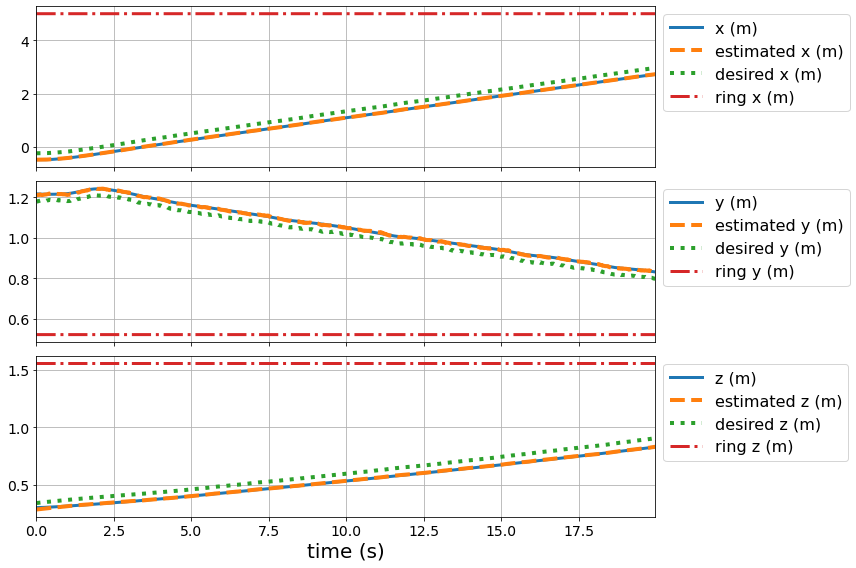

In [42]:
p_x_est = data['xhat'][:, 0]
p_y_est = data['xhat'][:, 1]
p_z_est = data['xhat'][:, 2]

p_x_des = data['xdes'][:, 0]
p_y_des = data['xdes'][:, 1]
p_z_des = data['xdes'][:, 2]

p_x_ring = data['ring'][:, 0]
p_y_ring = data['ring'][:, 1]
p_z_ring = data['ring'][:, 2]

# Create a figure with subplots that all share the same x-axis
fig, (ax_px, ax_py, ax_pz) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax_px.plot(data['t'], data['p_x'], label='x (m)', linewidth=3)
ax_px.plot(data['t'], p_x_est, '--', label='estimated x (m)', linewidth=4)
ax_px.plot(data['t'], p_x_des, ':', label='desired x (m)', linewidth=4)
ax_px.plot(data['t'], p_x_ring, '-.', label='ring x (m)', linewidth=3)
ax_px.grid()
ax_px.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_px.tick_params(labelsize=14)

ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=3)
ax_py.plot(data['t'], p_y_est, '--', label='estimated y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_des, ':', label='desired y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_ring, '-.', label='ring y (m)', linewidth=3)
ax_py.grid()
ax_py.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_py.tick_params(labelsize=14)

ax_pz.plot(data['t'], data['p_z'], label='z (m)', linewidth=3)
ax_pz.plot(data['t'], p_z_est, '--', label='estimated z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_des, ':', label='desired z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_ring, '-.', label='ring z (m)', linewidth=3)
ax_pz.grid()
ax_pz.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pz.tick_params(labelsize=14)

# Set shared x-axis properties
ax_pz.set_xlabel('time (s)', fontsize=20)
ax_pz.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Plot results (position, orientation, and actuator commands).

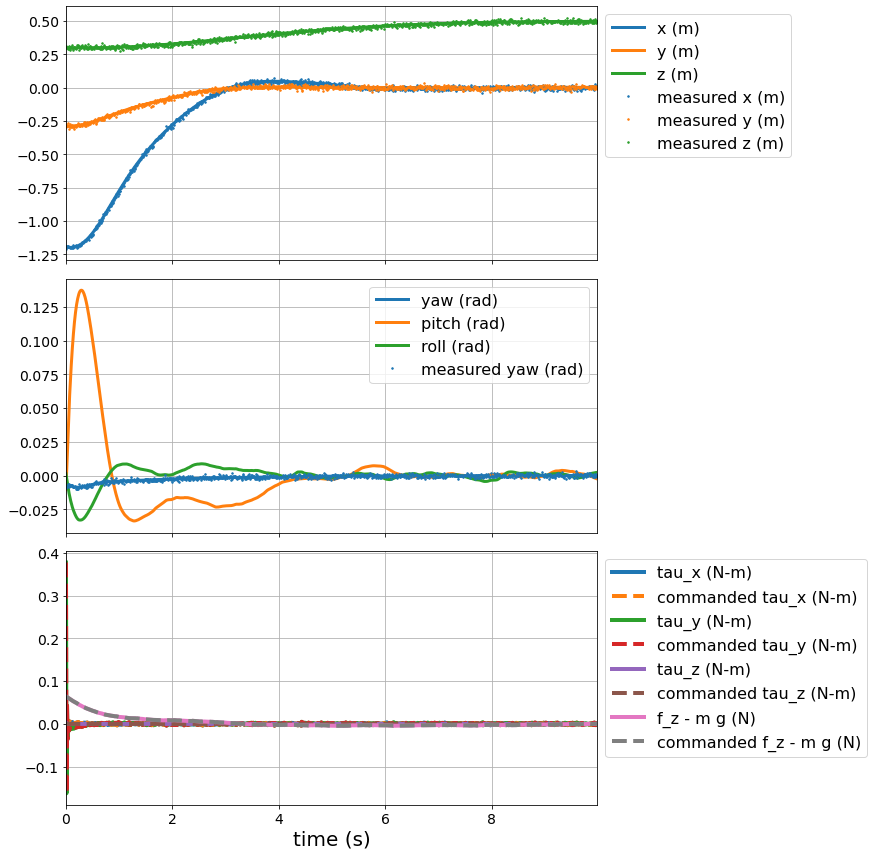

In [13]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['p_x_meas'], '.', label='measured x (m)', markersize=3, color='C0')
ax_pos.plot(data['t'], data['p_y_meas'], '.', label='measured y (m)', markersize=3, color='C1')
ax_pos.plot(data['t'], data['p_z_meas'], '.', label='measured z (m)', markersize=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.plot(data['t'], data['yaw_meas'], '.', label='measured yaw (rad)', markersize=3, color='C0')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
# ax_act.set_ylim(-10, 10) # <-- FIXME

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Plot histogram of controller run times.

In [ ]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get result.

In [ ]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('my_netid')

Show result.

In [ ]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

Get data.

In [ ]:
data = simulator.get_data('my_netid')

Plot results.

In [ ]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['p_x_meas'], '.', label='measured x (m)', markersize=3, color='C0')
ax_pos.plot(data['t'], data['p_y_meas'], '.', label='measured y (m)', markersize=3, color='C1')
ax_pos.plot(data['t'], data['p_z_meas'], '.', label='measured z (m)', markersize=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.plot(data['t'], data['yaw_meas'], '.', label='measured yaw (rad)', markersize=3, color='C0')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
# ax_act.set_ylim(-10, 10) # <-- FIXME

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot histogram of controller run times.

In [ ]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [ ]:
failures = simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.camera_droneview('tbretl')

In [ ]:
simulator.run(max_time=None)

## Example of how to show results, change views, keep running

Show results (so far).

In [ ]:
simulator.show_results()

View from behind a particular drone (assuming one exists that is named `template`).

In [ ]:
simulator.camera_droneview('template')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [ ]:
simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Show results (so far).

In [ ]:
simulator.show_results()

## Example of how to clear and reload drones

Clear all drones.

In [ ]:
simulator.clear_drones()

Load drones again from `students` directory.

In [ ]:
simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Display a snapshot.

In [ ]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Run simulation until `max_time` is reached or until all drones finish, saving movie to `my_video.mp4`.

In [ ]:
simulator.run(max_time=1.0, video_filename='my_video.mp4')

## Example of how to allow print statements and long run times

By default, your controller will fail if either of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `5e-3` seconds for `run`.

You can relax these rules for the purpose of development if you want, as follows.

In [ ]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)